In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import os
from torch import nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import seaborn as sns

In [65]:
# loop through all files in "data/good_data" and concatenta them into one dataframe
df = pd.concat([pd.read_csv(f"data/hold_good_data/{file}") for file in os.listdir("data/hold_good_data")])
# keep only common_name, condition, latitude_coordinate, longitude_coordinate, and native columns
df = df[['common_name', 'condition', 'latitude_coordinate', 'longitude_coordinate', 'native']]
# convert condition to numerical
df['condition'] = df['condition'].replace({'excellent': 4, 'good': 3, 'fair': 2, 'poor': 1, 'dead/dying': 0, 'dead': 0})
# one hot "common_name" column
df = pd.get_dummies(df, columns=["common_name"])
# one hot native column
df = pd.get_dummies(df, columns=["native"])
# drop native_no_info column
df.drop(columns=['native_no_info'], inplace=True)
# drop rows where condition is null
df = df.dropna(subset=['condition'])


In [66]:
# split into X and y
X = df.drop('condition', axis=1)
y = df['condition']

# convert from boolean to int
y = y.astype(int)
X = X.astype(float)

In [67]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert y data to numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [69]:
# convert to torch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [70]:
# train neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


In [71]:
# hyperparameters
input_size = len(X.columns)
hidden_size = 100
# set num_classes to be unique values in condition column
# num_classes = len(df['condition'].unique())
num_classes = 5
num_epochs = 100
batch_size = 100
learning_rate = 0.0001

# create model
model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [72]:
# train model
total_step = len(X_train)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i in range(0, total_step, batch_size):
        # get batch
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss_list.append(loss.item())
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accuracy
        total = y_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_batch).sum().item()
        acc_list.append(correct / total)
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {correct / total:.4f}')

Epoch [10/100], Loss: 0.6530, Accuracy: 0.7838
Epoch [20/100], Loss: 0.6397, Accuracy: 0.7838
Epoch [30/100], Loss: 0.6346, Accuracy: 0.7838
Epoch [40/100], Loss: 0.6304, Accuracy: 0.7838
Epoch [50/100], Loss: 0.6267, Accuracy: 0.7838
Epoch [60/100], Loss: 0.6236, Accuracy: 0.7838
Epoch [70/100], Loss: 0.6212, Accuracy: 0.7838
Epoch [80/100], Loss: 0.6192, Accuracy: 0.7838
Epoch [90/100], Loss: 0.6177, Accuracy: 0.7838
Epoch [100/100], Loss: 0.6164, Accuracy: 0.7838


In [73]:
# print the maximum accuracy achieved
print(f"Max accuracy: {max(acc_list)}")


Max accuracy: 0.94


In [74]:
# test model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(X_test)):
        inputs = X_test[i]
        label = y_test[i]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 0)
        total += 1
        correct += (predicted == label).sum().item()

print(f'Test Accuracy: {100 * correct / total:.4f}%')


Test Accuracy: 80.9913%


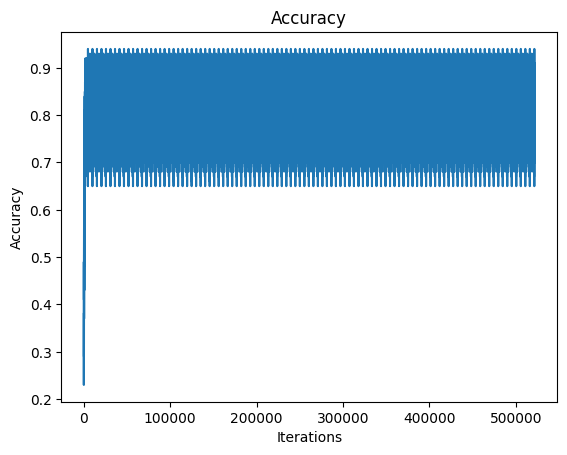

In [79]:
# plot accuracy for 100 epochs
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()
